# BLOOM Carbon Footprint : An Analysis of the logs

# Introduction

This notebook aims to analyse the SLURM logs of the experiments run on Jean Zay during the BigScience Project.
They were obtained using the `jobs_info.py` script.

## Data
The logs can be found in the Project-end folder.

## TODO
- Figure what is BLOOM or not, as we also have trained other models and created dataset

# Modules loading

In [38]:
import pandas as pd
import matplotlib
import os
import numpy as np

# Data loading, pre-processing and checks

In [39]:
# Read files into a single DataFrame
directory = "Project-end/"
file_paths = [directory+x for x in os.listdir(directory) if x.endswith("logs.txt")]
df_list = [pd.read_csv(filename, sep="|", header=None).assign(file=filename.split("/")[1]) for filename in file_paths]
df = pd.concat(df_list)
df.columns= ['job_id', 'num_V100_32GB', 'num_V100_16GB', 'num_A100_40GB', 'num_A100_80GB', \
             'alloc_cpu', 'alloc_mem', 'alloc_energy', 'partition', 'group', 'elapsed',\
              'qos','jobname', 'start', 'end', 'workdir', 'account' ,'file']

# Set display
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', -1) 

df.head(3)

/var/folders/_l/bj8z3bgn341fz_btklx56xfr0000gq/T/ipykernel_2368/3972656704.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,job_id,num_V100_32GB,num_V100_16GB,num_A100_40GB,num_A100_80GB,alloc_cpu,alloc_mem,alloc_energy,partition,group,elapsed,qos,jobname,start,end,workdir,account,file
0,771344,0,0,0,0,50.0,100G,25561382.0,cpu_p1,genini01,18:37:03,qos_cpu-t4,preprocess_oscar,2022-01-04T11:48:15,2022-01-05T06:25:18,/gpfsdswork/projects/rech/rcy/ulz63oj/BigScience-experiments,six@cpu,2022_08_24_roman_castagne_logs.txt
1,772361,0,0,0,0,NaN,NaN,NaN,cpu_p1,genini01,00:00:00,qos_cpu-t4,preprocess_oscar,2022-01-04T14:22:30,2022-01-04T14:22:30,/gpfsdswork/projects/rech/rcy/ulz63oj/BigScience-experiments,six@cpu,2022_08_24_roman_castagne_logs.txt
2,772368,0,0,0,0,NaN,NaN,NaN,cpu_p1,genini01,00:00:00,qos_cpu-t4,preprocess_oscar,2022-01-04T14:23:51,2022-01-04T14:23:51,/gpfsdswork/projects/rech/rcy/ulz63oj/BigScience-experiments,six@cpu,2022_08_24_roman_castagne_logs.txt


In [40]:
# Delete useless fields
df=df.drop(['alloc_energy','workdir'], axis=1)

# Cast datetimes as such
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'],  errors='coerce')

# We are going to make our own duration as elapsed field is sometimes buggy
df['elapsed'] = pd.to_timedelta(df['elapsed'])
df['duration'] = df['end'] - df['start']
df['duration_diff']= df['duration'] - df['elapsed']

# Hacky columns re-arrange
df=df[df.columns[[0,1,2,3,4,5,6,7,8,12,13,9,16,17,10,11,14,15]]] 

# Show example of elapsed time being bogus
df[df['duration_diff']>pd.to_timedelta(0)].head(3)

,job_id,num_V100_32GB,num_V100_16GB,num_A100_40GB,num_A100_80GB,alloc_cpu,alloc_mem,partition,group,start,end,elapsed,duration,duration_diff,qos,jobname,account,file
7,783484,0,0,0,0,2.0,4G,cpu_p1,genini01,2022-01-05 11:31:44,2022-01-06 13:30:08,-5 days +18:01:36,1 days 01:58:24,5 days 07:56:48,qos_cpu-t4,preprocess_oscar,six@cpu,2022_08_24_roman_castagne_logs.txt
8,783489,0,0,0,0,2.0,4G,cpu_p1,genini01,2022-01-05 11:31:44,2022-01-06 13:30:08,-5 days +18:01:36,1 days 01:58:24,5 days 07:56:48,qos_cpu-t4,preprocess_oscar,six@cpu,2022_08_24_roman_castagne_logs.txt
9,783491,0,0,0,0,2.0,4G,cpu_p1,genini01,2022-01-05 11:31:44,2022-01-06 13:30:08,-5 days +18:01:36,1 days 01:58:24,5 days 07:56:48,qos_cpu-t4,preprocess_oscar,six@cpu,2022_08_24_roman_castagne_logs.txt


In [41]:
# Compute GPU hours per hardware type
durations_in_hours = (df['duration'] / np.timedelta64(1, 's') / 3600)
df['hours_V100_32GB'] = df['num_V100_32GB'] * durations_in_hours
df['hours_V100_16GB'] = df['num_V100_16GB'] * durations_in_hours
df['hours_A100_40GB'] = df['num_A100_40GB'] * durations_in_hours
df['hours_A100_80GB'] = df['num_A100_80GB'] * durations_in_hours
df[df['hours_A100_80GB']>0].head(3)


,job_id,num_V100_32GB,num_V100_16GB,num_A100_40GB,num_A100_80GB,alloc_cpu,alloc_mem,partition,group,start,end,elapsed,duration,duration_diff,qos,jobname,account,file,hours_V100_32GB,hours_V100_16GB,hours_A100_40GB,hours_A100_80GB
758,662615,0,0,0,8,128.0,480000M,gpu_p5,six,2022-03-22 22:37:39,2022-03-22 23:09:43,0 days 00:32:04,0 days 00:32:04,0 days,qos_gpu-t3,bash,NaN,2022_08_24_thomwolf_jz_logs.txt,0.0,0.0,0.0,4.275556
2184,406772,0,0,0,384,6144.0,22500G,gpu_p5,genhug01,2022-06-12 00:31:16,2022-06-12 00:31:17,0 days 00:00:01,0 days 00:00:01,0 days,qos_gpu-gc,tr11-176B-ml,NaN,new_hugo_laurencon_jz_logs.txt,0.0,0.0,0.0,0.106667
4801,1677884,0,0,0,1,6.0,22500M,gpu_p5,genltc01,2022-07-29 19:59:56,2022-07-29 20:00:22,0 days 00:00:26,0 days 00:00:26,0 days,qos_gpu-t3,training,NaN,2022_08_01_pierrec_jz_logs.txt,0.0,0.0,0.0,0.007222


In [42]:
df.hours_A100_80GB.sum() # Capturing 99.3% of quotas, looking fine

1242577.3975

In [43]:
df.hours_V100_32GB.sum() + df.hours_V100_16GB.sum() # Capturing 115% of quotas, maybe quotas does not count all partitions?

2363314.7327777776

In [30]:
df_v100 = df[(df['hours_V100_32GB']>0) | (df['hours_V100_16GB']>0)]
df_v100.partition.value_counts()

gpu_p13    26142
gpu_p2     8338 
gpu_p2l    31   
gpu_p2s    25   
Name: partition, dtype: int64

In [44]:
# Compute GPU power for each job, assuming running at 100% TDP, using hardware info from JZ documentation --> http://www.idris.fr/eng/jean-zay/cpu/jean-zay-cpu-hw-eng.html
df['gpu_power_watts_hours'] = df['hours_V100_32GB'] * 300 # https://resources.nvidia.com/en-us-virtualization-and-gpus/v100-datasheet
df['gpu_power_watts_hours'] += df['hours_V100_16GB'] * 300 # https://resources.nvidia.com/en-us-virtualization-and-gpus/v100-datasheet
df['gpu_power_watts_hours'] += df['hours_A100_40GB'] * 250 # https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/A100-PCIE-Prduct-Brief.pdf
df['gpu_power_watts_hours'] += df['hours_A100_80GB'] * 400 # https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-nvidia-us-2188504-web.pdf

df[df['gpu_power_watts_hours']>0].head(3)

,job_id,num_V100_32GB,num_V100_16GB,num_A100_40GB,num_A100_80GB,alloc_cpu,alloc_mem,partition,group,start,end,elapsed,duration,duration_diff,qos,jobname,account,file,hours_V100_32GB,hours_V100_16GB,hours_A100_40GB,hours_A100_80GB,gpu_power_watts_hours
18,1127041,64,0,0,0,1280.0,2.50T,gpu_p13,six,2022-01-13 05:54:05,2022-01-13 06:22:04,0 days 00:27:59,0 days 00:27:59,0 days,qos_gpu-t3,mbert_alpha,six@gpu,2022_08_24_roman_castagne_logs.txt,29.848889,0.0,0.0,0.0,8954.666667
21,1308991,64,0,0,0,1280.0,2.50T,gpu_p13,six,2022-01-17 16:31:47,2022-01-17 16:35:37,0 days 00:03:50,0 days 00:03:50,0 days,qos_gpu-t3,mbert_alpha,six@gpu,2022_08_24_roman_castagne_logs.txt,4.088889,0.0,0.0,0.0,1226.666667
22,1314956,4,0,0,0,80.0,160G,gpu_p13,six,2022-01-17 18:29:49,2022-01-18 04:30:18,0 days 10:00:29,0 days 10:00:29,0 days,qos_gpu-t3,mbert_alpha,six@gpu,2022_08_24_roman_castagne_logs.txt,40.032222,0.0,0.0,0.0,12009.666667


<AxesSubplot:>

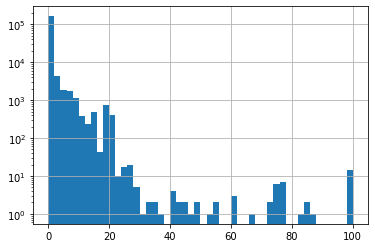

In [124]:
# Distribution of runs length
durations_in_hours = (df['duration'] / np.timedelta64(1, 's') / 3600)
durations_in_hours_for_hist = durations_in_hours[(durations_in_hours < 1000) & (durations_in_hours > 0) ] # remove few run of 200days...
durations_in_hours_for_hist.hist(bins=50,log=True)

# Data sanity checks

In [79]:
df[df['job_id']=='726762']

,job_id,num_V100_32GB,num_V100_16GB,num_A100_40GB,num_A100_80GB,alloc_cpu,alloc_mem,partition,group,start,end,elapsed,duration,duration_diff,qos,jobname,account,file
41517,726762,0,0,0,384,6144.0,22500G,gpu_p5,six,2022-03-25 11:09:19,2022-03-28 11:14:56,-10 days +16:54:23,3 days 00:05:37,12 days 07:11:14,qos_gpu-gc,tr11-176B-ml,NaN,2022_08_02_thomas_wang_jz_logs.txt


In [80]:
df['duration']

0       0 days 18:37:03
1       0 days 00:00:00
2       0 days 00:00:00
3       0 days 22:55:58
4       0 days 06:26:29
              ...      
39026   0 days 00:09:47
39027   0 days 00:11:51
39028   0 days 00:20:09
39029   0 days 00:20:54
39030   0 days 00:10:45
Name: duration, Length: 177192, dtype: timedelta64[ns]

In [81]:
df['duration'].sum()

Timedelta('5816 days 13:22:40')

In [82]:
df['file'].value_counts()

2022_08_02_thomas_wang_jz_logs.txt      45967
2022_08_08_luciles_logs.txt             39031
2022_08_01_stas_jz_logs.txt             38111
2022_08_25_victorsanh_jz_logs.txt       29049
2022-08-24_tvn_jz_logs.txt              11385
2022_08_01_muennighoff_jz_logs.txt      5139 
2022_08_01_pierrec_jz_logs.txt          4813 
new_hugo_laurencon_jz_logs.txt          2185 
2022_08_24_thomwolf_jz_logs.txt         760  
2022_08_02_younesb_jz_logs.txt          603  
2022_08_24_roman_castagne_logs.txt      110  
2022_08_01_sylvainv_jz_logs.txt         34   
2022_08_08_danielhesslow_jz_logs.txt    5    
Name: file, dtype: int64

# Main Bloom Training

In [125]:
# select only final training runs
bloomdf = df[df['jobname'] == 'tr11-176B-ml']
bloomdf.head(3)

,job_id,num_V100_32GB,num_V100_16GB,num_A100_40GB,num_A100_80GB,alloc_cpu,alloc_mem,partition,group,start,end,elapsed,duration,duration_diff,qos,jobname,account,file,hours_V100_32GB,hours_V100_16GB,hours_A100_40GB,hours_A100_80GB,gpu_power_watts_hours
2184,406772,0,0,0,384,6144.0,22500G,gpu_p5,genhug01,2022-06-12 00:31:16,2022-06-12 00:31:17,0 days 00:00:01,0 days 00:00:01,0 days,qos_gpu-gc,tr11-176B-ml,NaN,new_hugo_laurencon_jz_logs.txt,0.0,0.0,0.0,0.106667,42.666667
41501,417634,0,0,0,384,6144.0,22500G,gpu_p5,six,2022-03-11 18:09:15,2022-03-11 18:11:04,0 days 00:01:49,0 days 00:01:49,0 days,qos_gpu-gc,tr11-176B-ml,NaN,2022_08_02_thomas_wang_jz_logs.txt,0.0,0.0,0.0,11.626667,4650.666667
41502,417716,0,0,0,384,6144.0,22500G,gpu_p5,six,2022-03-11 18:18:33,2022-03-11 18:20:04,0 days 00:01:31,0 days 00:01:31,0 days,qos_gpu-gc,tr11-176B-ml,NaN,2022_08_02_thomas_wang_jz_logs.txt,0.0,0.0,0.0,9.706667,3882.666667


<AxesSubplot:>

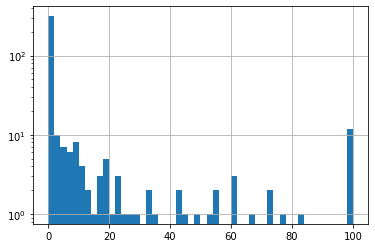

In [131]:
# Distribution of runs length
durations_in_hours = (bloomdf['duration'] / np.timedelta64(1, 's') / 3600)
durations_in_hours.hist(bins=50,log=True)

In [8]:
bloomdf['num_A100_80GB'].value_counts()

384    316
192    27 
0      20 
144    13 
288    8  
1      5  
32     4  
8      2  
16     2  
216    1  
Name: num_A100_80GB, dtype: int64

In [9]:
bloomdf.duration.sum()

Timedelta('118 days 05:40:42')

In [11]:
bloomdf.hours_A100_80GB.sum()

1082989.4766666668

In [10]:
bloomdf.gpu_power_watts_hours.sum() / 1000

433195.79066666664

# Other Trainings

In [16]:
traindf = df[df['jobname'].str.startswith('tr')]
traindf = traindf[traindf['jobname'] != 'tr11-176B-ml']
traindf = traindf[~traindf['jobname'].str.contains('sync')]
traindf = traindf[~traindf['jobname'].str.contains('slurm')]
traindf = traindf[~traindf['jobname'].str.contains('move')]
traindf = traindf[~traindf['jobname'].str.contains('eval')]
traindf = traindf[~traindf['jobname'].str.contains('tokenizer')]
traindf.shape

(6430, 18)

In [17]:
traindf['jobname'].value_counts()

tr6e-1B3-prefix-lm                                        1435
tr6f-1B3-prefix-lm                                        1431
tr6g-1B3-prefix-lm                                        1008
tr7d-1B3-alibi                                            433 
tr11                                                      302 
tr11-200B-ml                                              204 
tr8-104B                                                  153 
tr11f-6B3-ml                                              146 
tr8b-104B-cl                                              131 
tr8b-104B-bnb                                             123 
tr8b-104B-emb-norm                                        117 
tr13f-6B3-ml-t0                                           102 
tr5c-1B3-multilingual-alpha-alibi                         81  
tr11c-2B5-ml                                              78  
tr5d-1B3-multilingual-equal-alibi                         73  
tr11e-350M-ml                                          

In [18]:
traindf.duration.sum()

Timedelta('488 days 13:34:21')

# Eval

In [20]:
evaldf = df[df['jobname'].str.contains('eval')]
evaldf.shape

(16041, 18)

In [21]:
evaldf['jobname'].value_counts()

eval-tr3                                                                            3643
evaluate_t0                                                                         2337
eval_finetune-t5-xxl-lm-d4-091621                                                   747 
score_eval_finetune-t5-xxl-lm-d4-091621                                             694 
score_eval_finetune-t5-xxl-lm-d4-all-091621                                         671 
eval_baseline                                                                       534 
eval_finetune-t5-xxl-lm-d4-all-091621                                               531 
eval_finetune-t5-xl-lm-d4-091621                                                    530 
eval_finetune-t5-xxl-lm-d4-091621-512                                               530 
eval_finetune-t5-xxl-lm-d4-gpt-091621                                               514 
bs-eval-bloom-176b                                                                  504 
score_eval_finetune-t

# Tokenizer

In [23]:
tokendf = df[df['jobname'].str.contains('tokenizer')]
tokendf.shape

(103, 18)

In [24]:
tokendf['jobname'].value_counts()

train_tokenizer                                                 67
modelling-metadata-example-load-model-and-tokenizer             11
modelling-metadata-website-desc-load-model-and-tokenizer        8 
modelling-metadata-html-download-tokenizer-and-model            6 
compare_tokenizers                                              3 
modelling-metadata-entity-beg-load-model-and-tokenizer          2 
modelling-metadata-exp1-subexp3-load-model-and-tokenizer        2 
modelling-metadata-entity-load-model-and-tokenizer              1 
modelling-metadata-exp1-subexp1-load-model-and-tokenizer        1 
modelling-metadata-exp1-subexp2-load-model-and-tokenizer        1 
modelling-metadata-website-desc-load-model-and-tokenizer-25k    1 
Name: jobname, dtype: int64

# DATA PROCESSING, DOWNLOADING, DEDUPLICATION

In [255]:
datadf = df[df['jobname'].str.contains('data')]
datadf = datadf[~datadf['jobname'].str.contains('token')]
datadf.shape


(29359, 18)

In [256]:
datadf['jobname'].value_counts()

download_all_catalogue_datasets                                                     4507
pseudo_crawl_clean_dataset                                                          4282
preprocess_all_catalogue_datasets                                                   3146
modelling-metadata-c4-dataset-toy-add-metadata-full                                 2925
modelling-metadata-c4-dataset-toy-add-website-desc                                  2844
modelling-metadata-c4-dataset-export-to-jsonlines                                   2801
modelling-metadata-c4-dataset-toy-add-metadata-full-v3                              2761
filter_short_document_all_catalogue_datasets                                        1900
deduplicate_all_catalogue_datasets                                                  1121
modelling-metadata-c4-dataset-toy-add-metadata-full-v2                              873 
convert_datasets_to_jsonl                                                           609 
yong-download_dataset